<a href="https://colab.research.google.com/github/dsirt/Data-Engineering-Bootcamp/blob/main/KMeansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install delta-spark==2.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.4-py2.py3-none-any.whl size=311905460 sha256=7cf5acbacb4359b3ed876ef10a2003573b2ed4be528a7130c93858af96d6a52a
  Stored in directory: /root/.cache/pip/wheels/6b/0a/a1/2b8f5f192c7df9fdceb8e5a62873d64e46b101f980519bcf55
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.4
    Uninstalling pyspark-3.5.4:
      Successfully uninstalled pyspark-3.5.4


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('K-Means Clustering with Pyspark') \
    .getOrCreate()

In [4]:
df = spark.read.format('csv').\
    options(header = 'true', inferschema = 'true')\
    .load("/content/Iris.csv", header = 'True')

df.show(5)
df.printSchema()

+------------+-------------+-------------+------------+------+
|sepal-length| sepal-length| petal-length| petal-width| Class|
+------------+-------------+-------------+------------+------+
|           1|          5.1|          3.5|         1.4|   0.2|
|           2|          4.9|          3.0|         1.4|   0.2|
|           3|          4.7|          3.2|         1.3|   0.2|
|           4|          4.6|          3.1|         1.5|   0.2|
|           5|          5.0|          3.6|         1.4|   0.2|
+------------+-------------+-------------+------------+------+
only showing top 5 rows

root
 |-- sepal-length: integer (nullable = true)
 |--  sepal-length: double (nullable = true)
 |--  petal-length: double (nullable = true)
 |--  petal-width: double (nullable = true)
 |--  Class: double (nullable = true)



In [5]:
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+
|summary|      sepal-length|      sepal-length|       petal-length|       petal-width|             Class|
+-------+------------------+------------------+-------------------+------------------+------------------+
|  count|               150|               150|                150|               150|               150|
|   mean|              75.5| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|
| stddev|43.445367992456916|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|
|    min|                 1|               4.3|                2.0|               1.0|               0.1|
|    max|               150|               7.9|                4.4|               6.9|               2.5|
+-------+------------------+------------------+-------------------+------------------+------------------+



In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

# Veri dönüşüm fonksiyonu (sadece features sütunu ile)
def transData(data):
    return data.rdd.map(
        lambda r: Row(features=Vectors.dense(r))
    ).toDF()

# Dönüşüm işlemi
transformed = transData(df)
transformed.show(5, truncate=False)

+---------------------+
|features             |
+---------------------+
|[1.0,5.1,3.5,1.4,0.2]|
|[2.0,4.9,3.0,1.4,0.2]|
|[3.0,4.7,3.2,1.3,0.2]|
|[4.0,4.6,3.1,1.5,0.2]|
|[5.0,5.0,3.6,1.4,0.2]|
+---------------------+
only showing top 5 rows



In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol = "features", outputCol = 'indexedFeatures', maxCategories = 4).fit(transformed)

data = featureIndexer.transform(transformed)

data.show(5)

+--------------------+--------------------+
|            features|     indexedFeatures|
+--------------------+--------------------+
|[1.0,5.1,3.5,1.4,...|[1.0,5.1,3.5,1.4,...|
|[2.0,4.9,3.0,1.4,...|[2.0,4.9,3.0,1.4,...|
|[3.0,4.7,3.2,1.3,...|[3.0,4.7,3.2,1.3,...|
|[4.0,4.6,3.1,1.5,...|[4.0,4.6,3.1,1.5,...|
|[5.0,5.0,3.6,1.4,...|[5.0,5.0,3.6,1.4,...|
+--------------------+--------------------+
only showing top 5 rows



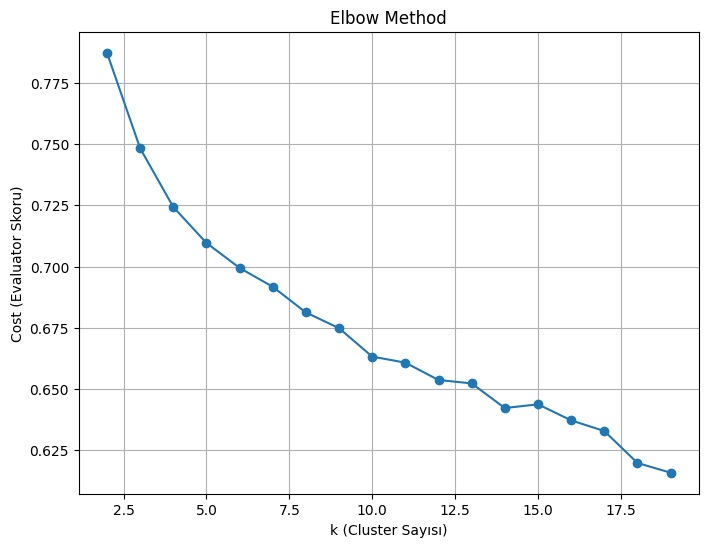

In [12]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Elbow Method için k değerlerini hesapla
costs = []
k_values = range(2, 20)

for k in k_values:
    kmeans = KMeans(k=k, seed=1, featuresCol="indexedFeatures")
    model = kmeans.fit(data)
    predictions = model.transform(data)

    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    costs.append(score)

# Elbow Method grafiği
plt.figure(figsize=(8, 6))
plt.plot(k_values, costs, marker='o')
plt.xlabel('k (Cluster Sayısı)')
plt.ylabel('Cost (Evaluator Skoru)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [13]:
#Pipeline Architecture

from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans().setK(3).setFeaturesCol("indexedFeatures").setPredictionCol("cluster")

pipeline = Pipeline(stages = [featureIndexer, kmeans])

model = pipeline.fit(transformed)

cluster = model.transform(transformed)

cluster.show(100)

+--------------------+--------------------+-------+
|            features|     indexedFeatures|cluster|
+--------------------+--------------------+-------+
|[1.0,5.1,3.5,1.4,...|[1.0,5.1,3.5,1.4,...|      0|
|[2.0,4.9,3.0,1.4,...|[2.0,4.9,3.0,1.4,...|      0|
|[3.0,4.7,3.2,1.3,...|[3.0,4.7,3.2,1.3,...|      0|
|[4.0,4.6,3.1,1.5,...|[4.0,4.6,3.1,1.5,...|      0|
|[5.0,5.0,3.6,1.4,...|[5.0,5.0,3.6,1.4,...|      0|
|[6.0,5.4,3.9,1.7,...|[6.0,5.4,3.9,1.7,...|      0|
|[7.0,4.6,3.4,1.4,...|[7.0,4.6,3.4,1.4,...|      0|
|[8.0,5.0,3.4,1.5,...|[8.0,5.0,3.4,1.5,...|      0|
|[9.0,4.4,2.9,1.4,...|[9.0,4.4,2.9,1.4,...|      0|
|[10.0,4.9,3.1,1.5...|[10.0,4.9,3.1,1.5...|      0|
|[11.0,5.4,3.7,1.5...|[11.0,5.4,3.7,1.5...|      0|
|[12.0,4.8,3.4,1.6...|[12.0,4.8,3.4,1.6...|      0|
|[13.0,4.8,3.0,1.4...|[13.0,4.8,3.0,1.4...|      0|
|[14.0,4.3,3.0,1.1...|[14.0,4.3,3.0,1.1...|      0|
|[15.0,5.8,4.0,1.2...|[15.0,5.8,4.0,1.2...|      0|
|[16.0,5.7,4.4,1.5...|[16.0,5.7,4.4,1.5...|      0|
|[17.0,5.4,3